In [1]:
import jax
jax.config.update("jax_enable_x64", True)

from transformer_payne import TransformerPayne
import matplotlib.pyplot as plt
import numpy as np

The model will be downloaded from the HuggingFace hub if it wasn't found in the passed cache directory (default=```'.cache'```).

In [2]:
emulator = TransformerPayne.download()

This is all you need! You can now work with spectra by passing in the:
- logarithms of wavelengths in [log($\AA$)]
- spectral parameter values (refer to ```emulator.parameter_names```)
- $\mu$ - cosine of the angle between the radius and the line-of-sight

In [3]:
wave = np.linspace(4670, 4960, 20000) # Angstrom (other widnows are also possible: 670 - 4960, 5620 - 5920, 6420 - 6790, 7540 - 7940 A)
spectral_parameters = emulator.solar_parameters # here we use solar parameters shipped with the model
mu = 1.0

# First call is longer as a function gets compiled
%time spectrum = emulator(np.log10(wave), mu, spectral_parameters).block_until_ready()

CPU times: user 3.72 s, sys: 296 ms, total: 4.02 s
Wall time: 2.82 s


In [4]:
# now when the function is compiled, for given log_wave.shape then the function is faster
# Changing the length of the wave vector will require recompilation
%time spectrum = emulator(np.log10(wave), mu, spectral_parameters).block_until_ready()

CPU times: user 1.56 s, sys: 80.3 ms, total: 1.64 s
Wall time: 401 ms


The ```TransformerPayne``` emulator return a 2D array - containing an intensity and continuum (intensity without lines).

If you want to take an intensity, continuum or compute normalised intensity run:

In [5]:
intensity = spectrum[:,0]
continuum = spectrum[:,1]
normalized_intensity = intensity / continuum

And now let take a look at our results:

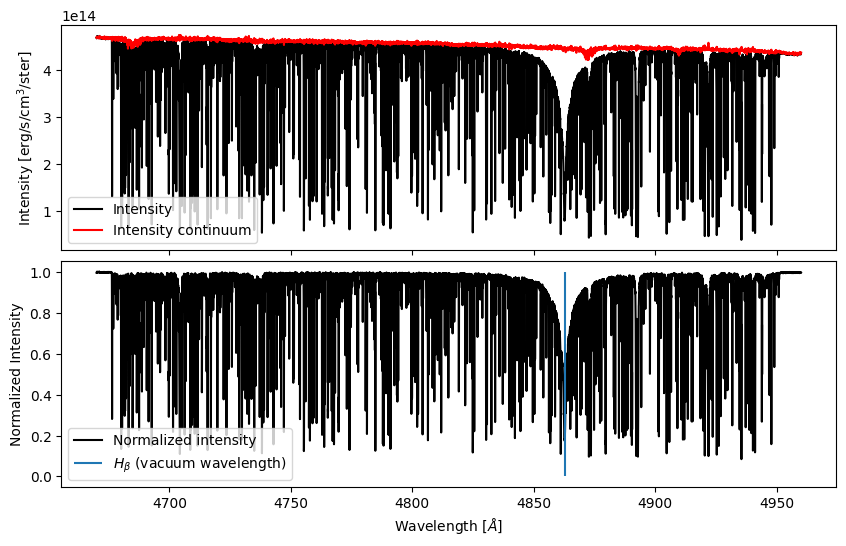

In [6]:
fig, axs = plt.subplots(2, sharex=True, figsize=(10, 6))
axs[0].plot(wave, intensity, color='black', label='Intensity')
axs[0].plot(wave, continuum, color='red', label='Intensity continuum')
axs[1].plot(wave, normalized_intensity, label="Normalized intensity", color='black')
axs[1].vlines(4862.721, 0, 1, color='C0', label=r'$H_\beta$ (vacuum wavelength)')  # Using raw string for LaTeX
axs[1].set_xlabel("Wavelength [$\AA$]")  # Corrected to set xlabel on the second subplot
axs[0].set_ylabel("Intensity [erg/s/cm$^3$/ster]")
axs[1].set_ylabel("Normalized Intensity")
axs[0].legend(loc="lower left")
axs[1].legend(loc="lower left")
plt.subplots_adjust(hspace=0.05)

### Manipulate individual abundaces

Spectral parameters are just a vector of floats:

In [7]:
spectral_parameters

array([ 3.76170237,  4.44      ,  1.        , 10.93      ,  1.05      ,
        1.38      ,  2.7       ,  8.39      ,  7.78      ,  8.66      ,
        4.56      ,  7.84      ,  6.17      ,  7.53      ,  6.37      ,
        7.51      ,  5.36      ,  7.14      ,  5.5       ,  6.18      ,
        5.08      ,  6.31      ,  3.17      ,  4.9       ,  4.        ,
        5.64      ,  5.39      ,  7.45      ,  4.92      ,  6.23      ,
        4.21      ,  4.6       ,  2.88      ,  3.58      ,  2.29      ,
        3.33      ,  2.56      ,  3.25      ,  2.6       ,  2.92      ,
        2.21      ,  2.58      ,  1.42      ,  1.92      , -5.        ,
        1.84      ,  1.12      ,  1.66      ,  0.94      ,  1.77      ,
        1.6       ,  2.        ,  1.        ,  2.19      ,  1.51      ,
        2.24      ,  1.07      ,  2.17      ,  1.13      ,  1.7       ,
        0.58      ,  1.45      , -5.        ,  1.        ,  0.52      ,
        1.11      ,  0.28      ,  1.14      ,  0.51      ,  0.93

To discover the meaning of each parameters you can call check field .parameter_names like below:


In [8]:
print(emulator.parameter_names)

['logteff', 'logg', 'vmic', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'mu']


Now lets assume that we want to calculate a spectrum of a star with the following parameters: Teff = 5000 K, logg = 4.5, and various [Mg/H]:

In [26]:
wave = np.linspace(7690, 7705, 1000) # Angstrom (other widnows are also possible: 4670 - 4960, 5620 - 5920, 6420 - 6790, 7540 - 7940 A)

logteff = np.log10(5000)
logg = 4.5

spectrum_Mg_03 = emulator(np.log10(wave), mu, emulator.to_parameters({"logteff":logteff, "logg":logg, "Mg":0.6}))
spectrum_Mg_00 = emulator(np.log10(wave), mu, emulator.to_parameters({"logteff":logteff, "logg":logg, "Mg":0.0}))
spectrum_Mg_m03 = emulator(np.log10(wave), mu, emulator.to_parameters({"logteff":logteff, "logg":logg, "Mg":-0.6}))

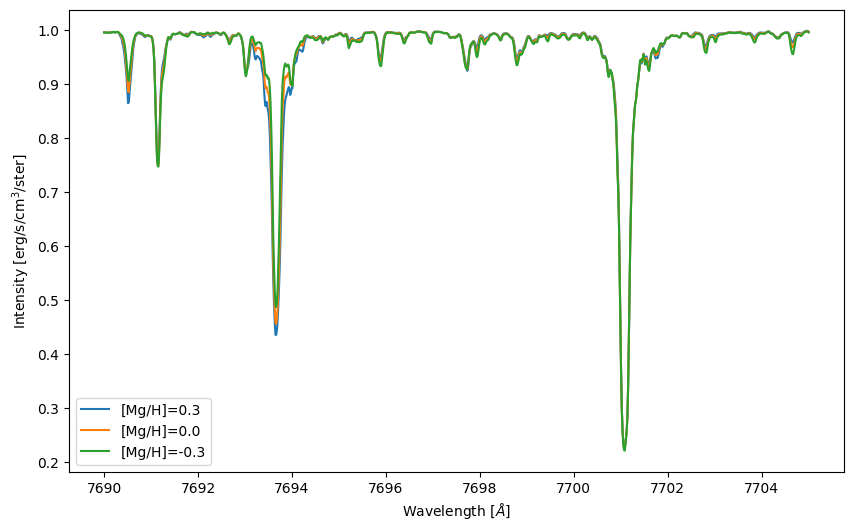

In [27]:
fix, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(wave, spectrum_Mg_03[:,0]/spectrum_Mg_03[:,1], label='[Mg/H]=0.3')
ax.plot(wave, spectrum_Mg_00[:,0]/spectrum_Mg_00[:,1], label='[Mg/H]=0.0')
ax.plot(wave, spectrum_Mg_m03[:,0]/spectrum_Mg_m03[:,1], label='[Mg/H]=-0.3')
ax.set_xlabel("Wavelength [$\AA$]")
ax.set_ylabel("Intensity [erg/s/cm$^3$/ster]")
ax.legend(loc="lower left")